# 1. 準備

### 1.1. 基本設定

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.dates as mdates
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


# カレントディレクトリを.pyと合わせるために以下を実行
if Path.cwd().name == "notebook":
    os.chdir("..")

# 設定
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_columns', 500)

# 浮動小数点数を小数点以下3桁で表示するように設定
pd.set_option('display.float_format', '{:.3f}'.format)

In [19]:
# Mac Matplotlibのデフォルトフォントをヒラギノ角ゴシックに設定
plt.rcParams['font.family'] = 'Hiragino Sans'

In [20]:
# Windows MatplotlibのデフォルトフォントをMeiryoに設定
plt.rcParams['font.family'] = 'Meiryo'

### 1.2. csv読み込み

In [21]:
# point_history.csvの読み込み
df_point_history_sorce = pd.read_csv('data/input/point_history_cleansing.csv')

C:\Users\noros\AppData\Local\Temp\ipykernel_32152\2496666113.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_point_history_sorce = pd.read_csv('data/input/point_history_cleansing.csv')


In [22]:
# ユーザー基本情報の読み込み
df_user_base_sorce = pd.read_csv("data/input/user_info_merged.csv")

### 1.3. データクレンジング

#### 1.3.1. df_user_base(ユーザ基本情報)のクレンジング

In [23]:
# DataFrameのコピーを作成
feature_list = [
    'id',
    'club_coin',
    'recycle_point',
    'total_recycle_amount',
    'recycle_amount_per_year',
    'recycle_amount_after_gold_member',
    'rank_continuation_class',
    'gender',
    '緯度',
    '経度',
    '登録日時',
    'カード登録',
    '最終利用日',
    '登録店舗との距離',
    '毎月平均リサイクル量',
    '毎月平均リサイクル回数',
    '毎月平均クラブコインの使用量',
    '毎月平均ガチャの取得量',
    '毎月平均ガチャの使用量',
    '平均rank',
    'サービス利用開始からの経過日数',
    'birthday'
    ]

df_user_base = df_user_base_sorce.copy()
df_user_base = df_user_base[feature_list]

# 紛らわしい列名を改名
df_user_base = df_user_base.rename(columns={'登録日時': 'アプリ登録日時', '最終利用日': 'アプリ最終利用日'})

# objectをdatetimeに変更
df_user_base['アプリ登録日時'] = pd.to_datetime(df_user_base['アプリ登録日時'], errors='coerce')
df_user_base['アプリ最終利用日'] = pd.to_datetime(df_user_base['アプリ最終利用日'], errors='coerce')
df_user_base['カード登録'] = pd.to_datetime(df_user_base['カード登録'], errors='coerce')
df_user_base['アプリ最終利用日'] = pd.to_datetime(df_user_base['アプリ最終利用日'], errors='coerce')
df_user_base['birthday'] = pd.to_datetime(df_user_base['birthday'], errors='coerce')

# 6歳未満(1543個)と100歳以上(12個)を削除
df_user_base = df_user_base[ (df_user_base['birthday'] < pd.to_datetime('2017-01-01')) & (df_user_base['birthday'] > pd.to_datetime('1924-01-01'))]

# df_user_baseに"age"と"age_group"のカラムを追加
df_user_base['age'] = pd.Timestamp.now().year - df_user_base['birthday'].dt.year    # ageの算出・追加

# 今回使用しない可能性が高いカラムは削除
df_user_base = df_user_base.sort_values(by='アプリ登録日時')

C:\Users\noros\AppData\Local\Temp\ipykernel_32152\1327706815.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_user_base['カード登録'] = pd.to_datetime(df_user_base['カード登録'], errors='coerce')


#### 1.3.2. df_point_history(point_history.csv)のクレンジング

## TODO:　store_latitude,store_longitudeと、userの緯度経度から、利用店舗との距離を算出してカラムに追加する

In [24]:
# DataFrameのコピーを作成
df_point_history = df_point_history_sorce.copy()

# objectをdatetimeに変更
df_point_history['use_date'] = pd.to_datetime(df_point_history['use_date'], errors='coerce')

feature_list_point = [
    'user_id',
    'super',
    'status',
    'shop_name_1',
    'amount_kg',
    'rank_id',
    'use_date',
    'store_latitude',
    'store_longitude',
    ]
df_point_history = df_point_history[feature_list_point]
df_point_history = df_point_history.sort_values(by='use_date')

# statusが1以外は削除
df_point_history = df_point_history[df_point_history['status'] == 1]

# amount_kgが0以下は削除
df_point_history = df_point_history[df_point_history['amount_kg'] > 0]


#### 1.3.3. 分析に必要なカラムの作成

継続利用期間（point_historyのuse_date列からRPS最終利用日を抽出したver.）　231228 norosen

In [25]:
# 各利用者id に対して「RPS利用開始日」「RPS最終利用日」を抽出
first_entries_RPS = df_point_history.groupby('user_id').first().reset_index()
last_entries_RPS = df_point_history.groupby('user_id').last().reset_index()

In [26]:
# df_user_baseに利用開始日をマージ
df_user_base = pd.merge(df_user_base, first_entries_RPS[['user_id', 'use_date']], left_on='id', right_on='user_id', how='left')
df_user_base = df_user_base.rename(columns={'use_date':'RPS利用開始日'})

# df_user_baseに最終利用日をマージ
df_user_base = pd.merge(df_user_base, last_entries_RPS[['user_id', 'use_date']], left_on='id', right_on='user_id', how='left')
df_user_base = df_user_base.rename(columns={'use_date':'RPS最終利用日'})


df_user_base['RPS利用開始日'] = pd.to_datetime(df_user_base['RPS利用開始日'], errors='coerce')
df_user_base['RPS最終利用日'] = pd.to_datetime(df_user_base['RPS最終利用日'], errors='coerce')

In [27]:
df_user_base = df_user_base.drop(columns=['user_id_x', 'user_id_y'])

In [28]:
# RPS継続利用期間を計算
df_user_base['RPS継続利用期間(月)'] = (df_user_base['RPS最終利用日'] - df_user_base['RPS利用開始日']).dt.days / 30  # 月単位で計算
df_user_base = df_user_base[df_user_base['RPS継続利用期間(月)'] >= 0]

#### 1.3.4. マージ

In [29]:
monthly_grouped_point = df_point_history.groupby(['user_id', df_point_history['use_date'].dt.to_period('M')])['amount_kg'].sum()
monthly_grouped_point = monthly_grouped_point.reset_index()

In [30]:
monthly_grouped_point.head()

,user_id,use_date,amount_kg
0,1,2020-11,100.000
1,1,2021-06,17.200
2,1,2021-07,26.650
3,1,2023-04,0.450
4,1,2023-11,0.200


In [31]:
pivot_df = monthly_grouped_point.pivot(index='user_id', columns='use_date', values='amount_kg')
pivot_df.head()

use_date,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN,NaN,NaN,NaN,17.200,26.650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450,NaN,NaN,NaN,NaN,NaN,NaN,0.200,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,36.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,11.650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,47.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,25.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,25.000,13.000,11.950,22.650,8.250,6.550,5.350,11.700,18.250,11.500,32.950,9.350,32.050,3.900,20.550,19.150,17.250,14.350,10.100,5.250,9.550,17.000,10.000,4.000,20.000,6.000,4.000,16.500,12.250,10.200,13.400,3.350,14.100,14.500,8.050,1.400,7.800,6.650,NaN,4.650,NaN,7.700,NaN,1.500,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000,5.000,33.000,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,9.450,16.150,21.000,19.280,17.450,25.160,34.430,17.000,17.120,69.200,17.660,75.350,15.900,23.300,17.550,16.050,21.000,19.350,44.480,44.550,42.090,15.330,19.030,15.300,15.000,NaN,6.120,23.000,45.400,NaN,19.080,18.090,8.170,119.620,1.000,NaN,NaN,18.350,107.750,8.250,12.800,NaN,25.250,29.850,6.100,46.900,NaN,NaN


In [32]:
# # 全ユーザーに対して、カバーすべき年月の範囲を特定します。
# date_range = pd.period_range(monthly_grouped_point['use_date'].min(), monthly_grouped_point['use_date'].max(), freq='M')

# # 全ユーザーIDを取得します。
# user_ids = monthly_grouped_point['user_id'].unique()

# # 全てのユーザーIDと年月の組み合わせを持つDataFrameを作成します。
# all_combinations = pd.MultiIndex.from_product([user_ids, date_range], names=['user_id', 'use_date'])

# # この新しいDataFrameを元のDataFrameとマージします。これにより、元になかった年月の組み合わせはNaNで埋められます。
# expanded_df = pd.DataFrame(index=all_combinations).reset_index()
# expanded_df = expanded_df.merge(monthly_grouped_point, on=['user_id', 'use_date'], how='left')

# # NaNを0で埋めます。
# expanded_df['amount_kg'] = expanded_df['amount_kg'].fillna(0)

# # 最後に'YearMonth'の形式を'YYYY-MM'に戻します。
# expanded_df['use_date'] = expanded_df['use_date'].dt.strftime('%Y-%m')

In [216]:
merged_df = pd.merge(pivot_df, df_user_base,  left_on='user_id', right_on='id', how='inner')

In [217]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72310 entries, 0 to 72309
Data columns (total 74 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   2020-01                           502 non-null    float64       
 1   2020-02                           518 non-null    float64       
 2   2020-03                           647 non-null    float64       
 3   2020-04                           591 non-null    float64       
 4   2020-05                           669 non-null    float64       
 5   2020-06                           599 non-null    float64       
 6   2020-07                           652 non-null    float64       
 7   2020-08                           697 non-null    float64       
 8   2020-09                           653 non-null    float64       
 9   2020-10                           629 non-null    float64       
 10  2020-11                           731 non-null

In [218]:
# merged_df['use_date'] = pd.to_datetime(merged_df['use_date'])
# merged_df['use_year'] = merged_df['use_date'].dt.year
# merged_df['use_month'] = merged_df['use_date'].dt.month
merged_df = merged_df.drop(columns = ['birthday',
                                      'RPS利用開始日',
                                      'RPS最終利用日',
                                      'アプリ最終利用日',
                                      'アプリ登録日時',
                                      'カード登録',
                                     ])

In [219]:
merged_df = pd.get_dummies(merged_df,columns=['gender'])

In [220]:
merged_df = merged_df.astype(float)

In [221]:
# first_columns = ['id', 'use_year', 'use_month', 'amount_kg']

# # first_columns に含まれていないカラムを抽出
# remaining_columns = [col for col in merged_df.columns if col not in first_columns]

# # 新しいカラムの順序を生成
# new_columns_order = first_columns + remaining_columns

# # DataFrameのカラムを新しい順序で再配置
# merged_df = merged_df[new_columns_order]

In [222]:
# merged_df = merged_df.sort_values(by = ['use_year','use_month'])

#### 標準化

In [223]:
merged_df.head(1)

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,id,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,緯度,経度,登録店舗との距離,毎月平均リサイクル量,毎月平均リサイクル回数,毎月平均クラブコインの使用量,毎月平均ガチャの取得量,毎月平均ガチャの使用量,平均rank,サービス利用開始からの経過日数,age,RPS継続利用期間(月),gender_女,gender_無回答,gender_男
0,NaN,NaN,11.650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.000,6.650,73.000,11.650,0.000,0.000,0.000,38.309,140.958,0.655,0.256,0.044,0.000,0.000,0.000,0.000,1366.000,45.000,0.167,0.000,0.000,1.000


In [224]:
# merged_df = merged_df.drop(['id',
#                             'use_year',
#                             'use_month',
#                             '緯度',
#                             '経度',
#                             'total_recycle_amount',
#                             'recycle_amount_after_gold_member',
#                             '2023-12'    # データ数が少ないため
                            
#                            ], axis=1)
merged_df = merged_df.iloc[:,24:47]   # 2022/1から

In [225]:
merged_df.head(10)

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,7.650,NaN,NaN,12.300,NaN,NaN,10.300,27.250,48.100,10.000,10.150,NaN,NaN,8.650,NaN,NaN,NaN,NaN
3,4.000,20.000,10.000,97.000,60.000,1.000,22.000,4.000,36.000,10.000,7.000,39.000,11.000,18.000,NaN,34.000,28.000,14.000,NaN,34.000,37.250,NaN,33.000
4,NaN,9.000,17.000,NaN,13.250,21.350,NaN,5.150,NaN,NaN,NaN,29.950,19.150,17.850,15.600,16.300,16.550,16.150,16.000,NaN,NaN,NaN,NaN
5,21.000,17.000,16.000,18.000,18.340,17.840,18.550,17.050,17.900,15.500,17.900,24.750,19.200,25.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14.360,16.120,NaN,29.570,15.690,0.360,19.440,13.800,NaN,NaN,15.250,NaN,8.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,29.000,8.000,19.000,18.000,12.850,16.700,22.500,22.990,13.200,13.850,10.600,12.900,14.400,13.050,8.050,14.750,10.200,16.500,12.850,9.200,11.550,15.000,2.250
8,23.000,NaN,20.000,27.250,NaN,24.500,20.600,NaN,NaN,NaN,19.050,32.750,NaN,10.900,14.100,16.000,NaN,30.550,NaN,21.700,NaN,30.500,20.750
9,18.000,19.000,NaN,21.000,21.500,23.050,13.700,17.050,21.840,19.800,NaN,40.500,NaN,15.750,20.900,13.600,NaN,22.660,20.950,NaN,18.950,23.000,NaN


In [226]:
merged_df = merged_df.fillna(0)

In [227]:
# dfの要素の値が30以上のものを30に変換
merged_df = merged_df.clip(upper=30)

In [228]:
merged_df = merged_df[~merged_df.apply(lambda x: (x <= 0).any() or (x >= 30).any(), axis=1)]

In [229]:
merged_df.max()

2022-01   29.000
2022-02   28.000
2022-03   29.450
2022-04   29.000
2022-05   29.000
2022-06   28.000
2022-07   28.000
2022-08   29.000
2022-09   29.000
2022-10   29.000
2022-11   29.000
2022-12   29.000
2023-01   29.000
2023-02   29.150
2023-03   29.000
2023-04   29.000
2023-05   29.000
2023-06   28.000
2023-07   29.000
2023-08   29.000
2023-09   28.000
2023-10   29.000
2023-11   29.000
dtype: float64

In [230]:
merged_df

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11
7,29.000,8.000,19.000,18.000,12.850,16.700,22.500,22.990,13.200,13.850,10.600,12.900,14.400,13.050,8.050,14.750,10.200,16.500,12.850,9.200,11.550,15.000,2.250
51,16.000,15.000,16.000,18.000,17.200,16.000,15.750,16.550,17.200,15.300,15.600,15.500,15.400,15.150,15.000,15.450,15.400,16.500,17.000,29.000,19.000,25.000,21.000
56,15.000,15.000,15.000,15.000,15.250,15.150,15.200,15.000,15.100,15.150,15.200,15.150,15.100,15.100,15.050,15.300,15.100,15.050,15.100,15.100,15.150,15.100,15.150
75,16.000,23.000,24.000,20.000,20.800,15.450,16.500,24.850,15.550,17.340,17.500,18.250,17.900,16.800,16.400,16.250,19.100,17.100,18.050,17.000,16.150,18.650,17.900
107,25.000,23.000,18.000,18.000,16.950,24.100,15.500,18.850,16.250,17.950,17.500,20.000,25.350,17.200,26.450,23.000,17.400,20.350,16.150,17.300,16.550,19.400,16.400
273,15.000,15.000,19.000,16.000,16.850,16.050,17.200,16.800,15.200,19.150,16.100,18.250,16.750,15.400,16.550,17.550,16.350,15.050,16.000,15.950,17.250,15.500,15.100
463,20.000,25.000,16.000,19.000,20.200,23.600,23.350,16.160,20.050,16.250,20.300,17.500,15.200,20.300,18.850,16.150,17.750,19.350,22.250,21.100,22.650,20.550,26.400
479,16.000,19.000,16.000,19.000,16.550,18.100,17.500,14.400,14.250,22.500,18.300,18.950,22.100,16.050,16.550,18.100,14.300,15.300,17.250,18.000,11.300,22.950,15.700
551,14.000,5.000,2.000,9.000,15.000,10.000,4.000,14.500,7.500,16.500,2.000,13.500,25.500,11.000,11.500,13.000,10.500,9.500,15.000,17.000,10.500,10.500,8.000
561,11.000,6.000,21.000,4.000,10.500,18.500,14.500,5.000,6.500,9.000,6.000,16.500,7.000,9.500,6.500,6.500,3.000,12.000,6.000,6.000,3.500,5.500,15.500


In [231]:
# StandardScalerのインスタンスを作成
scaler = StandardScaler()

# データフレームの全列を標準化
# ここでは、ID列など、標準化不要な列は除外する必要があります
columns_to_scale = merged_df.columns.difference(['gender_女',
                                               'gender_無回答',
                                               'gender_男'])
merged_df[columns_to_scale] = scaler.fit_transform(merged_df[columns_to_scale])

#### Xとyに分割

In [232]:
X = merged_df.drop(merged_df.columns[-1], axis=1)
y = merged_df[merged_df.columns[-1]]

In [233]:
X.head()

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10
7,2.383,-1.057,0.677,0.513,-0.330,0.406,1.452,1.500,-0.128,-0.195,-0.620,-0.589,0.025,-0.034,-1.228,0.027,-0.661,0.519,-0.214,-0.926,-0.359,0.062
51,0.058,0.183,0.142,0.513,0.449,0.281,0.171,0.391,0.581,0.067,0.274,-0.071,0.199,0.329,0.047,0.153,0.258,0.519,0.539,2.648,0.943,1.717
56,-0.121,0.183,-0.036,-0.039,0.100,0.130,0.066,0.124,0.209,0.040,0.202,-0.140,0.147,0.321,0.056,0.126,0.205,0.251,0.194,0.139,0.270,0.078
75,0.058,1.600,1.569,0.881,1.093,0.184,0.313,1.820,0.289,0.436,0.614,0.478,0.633,0.615,0.303,0.297,0.912,0.629,0.729,0.482,0.445,0.666
107,1.668,1.600,0.499,0.513,0.404,1.723,0.123,0.787,0.413,0.546,0.614,0.827,1.925,0.684,2.147,1.512,0.611,1.229,0.385,0.536,0.515,0.790


In [234]:
y.head()

7     -2.055
51     1.263
56     0.228
75     0.714
107    0.449
Name: 2023-11, dtype: float64

# 2. 予測

#### trainとtestに分割

In [235]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

evals_result = {}  # 学習過程を記録するための辞書

# LightGBMのパラメータ設定
lgb_params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'seed': 0,
    'num_iterations' : 1000, # 値を小さくするとよい
    'learning_rate' : 0.02,
    'max_depth': 8,
    'num_leaves': 2**8,
    'metric': 'rmse'
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)



#### 学習

In [236]:
# トレーニングの進捗を表示するコールバックを追加
model = lgb.train(
    lgb_params, 
    train_data, 
    valid_sets=[train_data, test_data], 
    callbacks=[
        lgb.callback.log_evaluation(period=50),
        lgb.callback.early_stopping(stopping_rounds=1000),
        lgb.callback.record_evaluation(evals_result)
    ]
)

c:\Users\noros\anaconda3\envs\patchworks\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 297, number of used features: 22
[LightGBM] [Info] Start training from score -0.006840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 1000 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

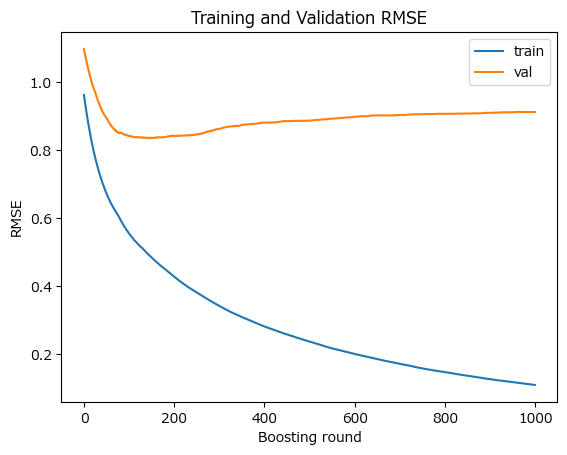

In [237]:
# RMSE の学習曲線をプロット
plt.plot(evals_result['training']['rmse'], label='train')
plt.plot(evals_result['valid_1']['rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Boosting round')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

#### 予測

In [238]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

#### 評価

In [239]:
# Evaluate the predictions
# Calculate and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

print("actual")
print(y_test[:10].values)
print("pred")
print(y_pred[:10])

Mean Squared Error (MSE): 0.6980158219951712
Mean Absolute Error (MAE): 0.6063934144333412
Root Mean Squared Error (RMSE): 0.8354734119020013
R-squared (R2): 0.42697924395083764
actual
[ 0.20117415 -1.56801694 -1.48840335 -1.92185516  0.90885059  0.37809326
  0.90885059  0.55501237  1.2626888   1.08576969]
pred
[ 0.98707595 -1.0591475  -1.32180972 -0.89982182  0.70226018 -0.17580391
 -0.70974726  0.15494038  0.36936848  0.93273714]


In [240]:
#スケールをもとに戻す
y_pred = y_pred*scaler.scale_[-1] + scaler.mean_[-1]
y_train = y_train*scaler.scale_[-1] + scaler.mean_[-1]
y_test = y_test*scaler.scale_[-1] + scaler.mean_[-1]

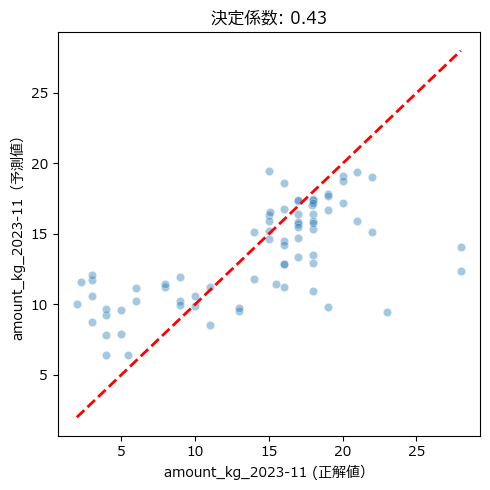

In [241]:
# actual vs. pred の散布図
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.title('決定係数: {}'.format(round(r2, 2)))
plt.xlabel('amount_kg_2023-11 (正解値）')
plt.ylabel('amount_kg_2023-11（予測値）')

# 拡大用
# plt.xlim([-10,2])
# plt.ylim([-10,2])

# Plot a line representing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.tight_layout()
plt.show()